<a href="https://colab.research.google.com/github/daniel-h-warwick/warwick-aai-files/blob/main/Python_concurrency_and_parallelism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Advanced: Concurrency and Parallelism

This notebook mirrors the LiaScript lesson and keeps the examples runnable with extra guidance for beginners. You will learn when to use threading, multiprocessing, and asyncio to keep programs responsive and fast.

**Prerequisites:** comfortable with Python functions, loops, and basic exception handling.

**You will be able to:**
- Distinguish concurrency, parallelism, and asynchronous programming
- Choose between threading, multiprocessing, and asyncio for different workloads
- Spot issues like race conditions and deadlocks
- Apply these ideas to web scraping, data processing, and API-heavy code

## Concurrency vs. Parallelism

- **Concurrency**: dealing with many tasks at once by switching between them (great when tasks wait for I/O).
- **Parallelism**: doing multiple tasks at the exact same time on different CPU cores.
- Python gives you three main tools:
  1. **Threading**: many threads in one process (best for I/O-bound work).
  2. **Multiprocessing**: many processes with separate memory (best for CPU-bound work).
  3. **Asyncio**: cooperative multitasking with `async`/`await` (great for lots of network-bound tasks).
  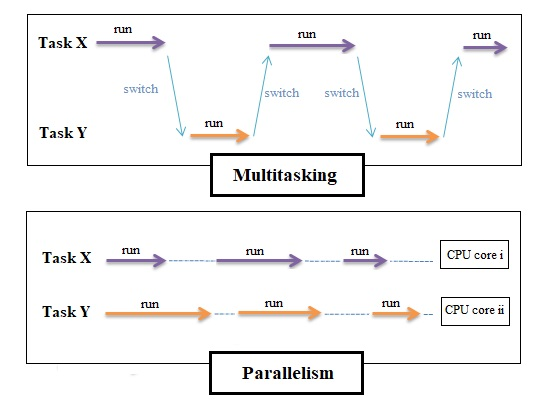
  Image source: Codeproject.com

## The Global Interpreter Lock (GIL)

The GIL is a lock in CPython that allows only one thread to run Python bytecode at a time. Effects:
- Threading can speed up I/O-bound work because threads often wait for I/O, but it will **not** speed up CPU-heavy code.
- Multiprocessing avoids the GIL by using separate processes, so it can speed up CPU-bound work.

In [1]:
import threading
import time


def cpu_intensive_task(n: int) -> int:
    """Simulate CPU-bound work by doing many math operations."""
    total = 0
    for i in range(n):
        total += i ** 2
    return total


# Single-threaded execution
start = time.perf_counter()
result1 = cpu_intensive_task(1_000_000)
result2 = cpu_intensive_task(1_000_000)
single_duration = time.perf_counter() - start
print(f"Single-threaded: {single_duration:.3f}s")

# Multi-threaded execution (the GIL prevents a speedup for CPU-bound work)
start = time.perf_counter()
thread1 = threading.Thread(target=cpu_intensive_task, args=(1_000_000,))
thread2 = threading.Thread(target=cpu_intensive_task, args=(1_000_000,))
thread1.start()
thread2.start()
thread1.join()
thread2.join()
threaded_duration = time.perf_counter() - start
print(f"Multi-threaded: {threaded_duration:.3f}s")
print(f"Threading speedup: {single_duration / threaded_duration:.2f}x")


Single-threaded: 0.213s
Multi-threaded: 0.318s
Threading speedup: 0.67x


**What to notice:** even with two threads, the CPU-heavy loop does not get faster because the GIL lets only one thread execute Python bytecode at a time. Use multiprocessing for CPU-bound work instead.

## Threading Basics

Threading runs multiple threads inside one process. Threads share memory, which makes sharing data easy but requires synchronization when writing to shared objects.

In [2]:
import threading
import time


def download_file(file_id: int) -> str:
    """Pretend to download a file; here we just sleep to simulate network delay."""
    print(f"Starting download {file_id}")
    time.sleep(0.5)  # Simulate network latency
    print(f"Finished download {file_id}")
    return f"data_{file_id}"


print("=== Sequential Downloads ===")
start = time.perf_counter()
for i in range(4):
    download_file(i)
sequential_duration = time.perf_counter() - start
print(f"Sequential time: {sequential_duration:.2f}s")

print("=== Concurrent Downloads (Threading) ===")
start = time.perf_counter()
threads = []
for i in range(4):
    thread = threading.Thread(target=download_file, args=(i,))
    threads.append(thread)
    thread.start()

# Wait for every thread to finish before measuring time
for thread in threads:
    thread.join()

threaded_duration = time.perf_counter() - start
print(f"Threaded time: {threaded_duration:.2f}s")
print(f"Speedup: {sequential_duration / threaded_duration:.2f}x")


=== Sequential Downloads ===
Starting download 0
Finished download 0
Starting download 1
Finished download 1
Starting download 2
Finished download 2
Starting download 3
Finished download 3
Sequential time: 2.01s
=== Concurrent Downloads (Threading) ===
Starting download 0
Starting download 1
Starting download 2
Starting download 3
Finished download 0
Finished download 3
Finished download 1
Finished download 2
Threaded time: 0.50s
Speedup: 3.99x


**Quiz:** When is threading most beneficial?

- [ ] CPU-intensive math computations
- [x] Downloading many files from the internet
- [ ] Sorting huge arrays entirely in memory
- [ ] Computing prime numbers

Threading shines when tasks mostly wait for I/O.

## Thread Safety and Locks

When threads update shared data, use locks to avoid race conditions. A `Lock` ensures only one thread enters a protected block at a time.

In [3]:
import threading
import time
import random


class BankAccount:
    """Simulates a bank account with thread-safe operations."""

    def __init__(self, initial_balance: float = 1000.0):
        self.balance = initial_balance
        self.lock = threading.Lock()
        self.transaction_count = 0

    def deposit(self, amount: float, account_holder: str):
        """Safely deposit money into the account."""
        with self.lock:
            print(f"{account_holder} depositing ${amount:.2f}")
            current_balance = self.balance
            time.sleep(0.01)  # Simulate processing time
            self.balance = current_balance + amount
            self.transaction_count += 1
            print(f"{account_holder} deposited ${amount:.2f}. New balance: ${self.balance:.2f}")

    def withdraw(self, amount: float, account_holder: str) -> bool:
        """Safely withdraw money from the account."""
        with self.lock:
            print(f"{account_holder} attempting to withdraw ${amount:.2f}")
            if self.balance >= amount:
                current_balance = self.balance
                time.sleep(0.01)  # Simulate processing time
                self.balance = current_balance - amount
                self.transaction_count += 1
                print(f"{account_holder} withdrew ${amount:.2f}. New balance: ${self.balance:.2f}")
                return True
            else:
                print(f"{account_holder} withdrawal failed - insufficient funds")
                return False

    def get_balance(self) -> float:
        """Thread-safe balance inquiry."""
        with self.lock:
            return self.balance


def perform_transactions(account: BankAccount, person_name: str, num_transactions: int):
    """Perform random deposits and withdrawals."""
    for _ in range(num_transactions):
        action = random.choice(['deposit', 'withdraw'])
        amount = random.uniform(10, 100)

        if action == 'deposit':
            account.deposit(amount, person_name)
        else:
            account.withdraw(amount, person_name)

        time.sleep(random.uniform(0.01, 0.05))


# Create a shared bank account
print("=== Bank Account Simulation with Thread Safety ===")
account = BankAccount(initial_balance=1000.0)
print(f"Initial balance: ${account.get_balance():.2f}\n")

# Multiple people accessing the same account concurrently
people = ["Alice", "Bob", "Charlie"]
transaction_threads = []

for person in people:
    thread = threading.Thread(target=perform_transactions, args=(account, person, 5))
    transaction_threads.append(thread)
    thread.start()

# Wait for all transactions to complete
for thread in transaction_threads:
    thread.join()

print(f"\n=== Final Results ===")
print(f"Final balance: ${account.get_balance():.2f}")
print(f"Total transactions: {account.transaction_count}")

=== Bank Account Simulation with Thread Safety ===
Initial balance: $1000.00

Alice attempting to withdraw $23.69
Alice withdrew $23.69. New balance: $976.31
Bob depositing $62.67
Bob deposited $62.67. New balance: $1038.97
Charlie attempting to withdraw $80.46
Charlie withdrew $80.46. New balance: $958.52
Alice attempting to withdraw $53.60
Alice withdrew $53.60. New balance: $904.92
Bob depositing $42.40
Bob deposited $42.40. New balance: $947.33
Charlie depositing $81.02
Charlie deposited $81.02. New balance: $1028.34
Bob depositing $17.41
Bob deposited $17.41. New balance: $1045.76
Alice depositing $15.93
Alice deposited $15.93. New balance: $1061.68
Charlie attempting to withdraw $20.62
Charlie withdrew $20.62. New balance: $1041.06
Alice attempting to withdraw $28.40
Alice withdrew $28.40. New balance: $1012.66
Charlie depositing $49.93
Charlie deposited $49.93. New balance: $1062.59
Bob depositing $27.49
Bob deposited $27.49. New balance: $1090.08
Alice depositing $48.68
Alice d

## Thread Safety and Locks Exercise:
Try the same code without Lock and check the result.

In [4]:
import threading
import time


class UnsafeCounter:
    def __init__(self):
        self.count = 0

    def increment(self):
        # No lock: two threads can read the same value and overwrite each other
        current = self.count
        current += 1
        time.sleep(0.01)
        self.count = current


class SafeCounter:
    def __init__(self):
        self.count = 0
        self.lock = threading.Lock()

    def increment(self):
        # Lock prevents overlapping writes
        with self.lock:
            current = self.count
            current += 1
            time.sleep(0.01)
            self.count = current


def worker(counter, iterations: int):
    for _ in range(iterations):
        counter.increment()


# Unsafe counter test
unsafe = UnsafeCounter()
threads = [threading.Thread(target=worker, args=(unsafe, 1000)) for _ in range(5)]
for t in threads:
    t.start()
for t in threads:
    t.join()
print(f"Unsafe counter: {unsafe.count}")

# Safe counter test
safe = SafeCounter()
threads = [threading.Thread(target=worker, args=(safe, 1000)) for _ in range(5)]
for t in threads:
    t.start()
for t in threads:
    t.join()
print(f"Safe counter: {safe.count}")


Unsafe counter: 1000


KeyboardInterrupt: 

Locks add overhead but prevent data races. Use them around writes to shared mutable state, or prefer thread-safe data structures.

## ThreadPoolExecutor for Easier Threading

`concurrent.futures.ThreadPoolExecutor` manages a pool of worker threads for you. Submit callables and collect results as they finish.

In [5]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import time


def process_data(item_id: int):
    """Simulate processing a data item that is I/O-bound."""
    time.sleep(0.2)
    return f"Processed item {item_id}", item_id * 2


print("=== Processing with ThreadPoolExecutor ===")
start = time.perf_counter()

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(process_data, i) for i in range(10)]

    for future in as_completed(futures):
        message, result = future.result()
        print(f"{message}: {result}")

duration = time.perf_counter() - start
print(f"Total time: {duration:.2f}s")


=== Processing with ThreadPoolExecutor ===
Processed item 0: 0
Processed item 1: 2
Processed item 2: 4
Processed item 3: 6
Processed item 5: 10
Processed item 6: 12
Processed item 4: 8
Processed item 7: 14
Processed item 8: 16
Processed item 9: 18
Total time: 0.60s


`ThreadPoolExecutor` is ideal when you want simple parallel I/O without manually creating and tracking threads.

## Multiprocessing for CPU-Bound Tasks

Use the `multiprocessing` module to run CPU-heavy code in separate processes. Each process has its own Python interpreter, so the GIL is not a bottleneck.

In [ ]:
import multiprocessing
import os
import time

def cpu_heavy_task(x):
    """
    A CPU-intensive task that calculates the sum of squares up to x.
    It prints the Process ID (PID) to show which process is executing it.
    """
    pid = os.getpid()
    print(f"Task {x} started on Process ID: {pid}")

    # Simulate heavy computation
    result = sum(i * i for i in range(x))

    return f"Task {x} result: {result} (Processed by PID {pid})"

# Prepare a list of inputs for the heavy task
inputs = [1000000, 2000000, 3000000, 4000000]

print(f"Main Process ID: {os.getpid()}")
print("Starting multiprocessing pool...")

# Create a Pool of worker processes.
# By default, it creates one worker per CPU core available.
# Since these are separate processes, each has its own memory and Python interpreter (GIL).
with multiprocessing.Pool() as pool:
    # pool.map distributes the inputs across the worker processes
    # and collects the results in a list.
    results = pool.map(cpu_heavy_task, inputs)

print("\nAll tasks completed. Results:")
for res in results:
    print(res)

Main Process ID: 298
Starting multiprocessing pool...
Task 1000000 started on Process ID: 2468
Task 2000000 started on Process ID: 2469
Task 3000000 started on Process ID: 2468
Task 4000000 started on Process ID: 2469

All tasks completed. Results:
Task 1000000 result: 333332833333500000 (Processed by PID 2468)
Task 2000000 result: 2666664666667000000 (Processed by PID 2469)
Task 3000000 result: 8999995500000500000 (Processed by PID 2468)
Task 4000000 result: 21333325333334000000 (Processed by PID 2469)


Please run the below code in VS Code. And think why Colab is not a good place to run this code?

In [6]:
import multiprocessing
import os
import time

def cpu_heavy_task(x):
    """
    A CPU-intensive task that calculates the sum of squares up to x.
    It prints the Process ID (PID) to show which process is executing it.
    """
    pid = os.getpid()
    print(f"Task {x} started on Process ID: {pid}")

    # Simulate heavy computation
    result = sum(i * i for i in range(x))

    return f"Task {x} result: {result} (Processed by PID {pid})"

if __name__ == "__main__":
    # Prepare a list of inputs for the heavy task
    inputs = [1000000, 2000000, 3000000, 4000000]
    print(f"Main Process ID: {os.getpid()}")
    print("Starting multiprocessing pool...")

    # Create a Pool of worker processes.
    # By default, it creates one worker per CPU core available.
    # Since these are separate processes, each has its own memory and Python interpreter (GIL).
    with multiprocessing.Pool() as pool:
        # pool.map distributes the inputs across the worker processes
        # and collects the results in a list.
        results = pool.map(cpu_heavy_task, inputs)

    print("\nAll tasks completed. Results:")
    for res in results:
        print(res)


Main Process ID: 646
Starting multiprocessing pool...
Task 1000000 started on Process ID: 5875
Task 2000000 started on Process ID: 5876
Task 3000000 started on Process ID: 5875
Task 4000000 started on Process ID: 5876

All tasks completed. Results:
Task 1000000 result: 333332833333500000 (Processed by PID 5875)
Task 2000000 result: 2666664666667000000 (Processed by PID 5876)
Task 3000000 result: 8999995500000500000 (Processed by PID 5875)
Task 4000000 result: 21333325333334000000 (Processed by PID 5876)


Multiprocessing can approach linear speedup for CPU work when you have enough cores. Remember that processes do not share memory.

## Process Communication with Queues

Because processes do not share memory, you need explicit communication. `multiprocessing.Queue` provides safe, cross-process message passing.

In [7]:
import multiprocessing
import time


def producer(queue, items):
    """Produce items and put them on the queue."""
    for item in items:
        print(f"Producing {item}")
        queue.put(item)
        time.sleep(0.1)
    queue.put(None)  # Sentinel value to signal completion


def consumer(queue):
    """Consume items until the sentinel arrives."""
    while True:
        item = queue.get()
        if item is None:
            break
        print(f"Consuming {item}")
        time.sleep(0.15)


queue = multiprocessing.Queue()
items = ["data_1", "data_2", "data_3", "data_4"]

producer_process = multiprocessing.Process(target=producer, args=(queue, items))
consumer_process = multiprocessing.Process(target=consumer, args=(queue,))

producer_process.start()
consumer_process.start()

producer_process.join()
consumer_process.join()

print("All processing complete")


Producing data_1
Consuming data_1
Producing data_2
Consuming data_2
Producing data_3
Producing data_4
Consuming data_3
Consuming data_4
All processing complete


Queues make it easy to build producer-consumer pipelines without sharing mutable state directly.

## Introduction to Asyncio

Asyncio lets one thread juggle many I/O-bound tasks by switching when tasks await I/O. It is ideal for thousands of network operations.

In [8]:
import asyncio   # Built-in library for asynchronous (non-blocking) programming
import time      # Used here just to measure elapsed time


# Define an *asynchronous* function (a coroutine) using `async def`
async def fetch_data(source_id: int, delay: float):
    """Simulate fetching data from a remote source."""
    # This prints immediately when the coroutine starts running
    print(f"Fetching from source {source_id}...")

    # Non-blocking sleep: while this task is "waiting", other tasks can run
    # In async code we use `await asyncio.sleep(...)` instead of `time.sleep(...)`
    await asyncio.sleep(delay)

    # This prints after the delay has passed
    print(f"Received data from source {source_id}")

    # Return some fake "data" for this source
    return f"data_{source_id}"


# Another coroutine that coordinates everything
async def main():
    # Take a high-precision timestamp so we can measure total runtime
    start = time.perf_counter()

    # Create a list of coroutine objects for four different "fetch" operations.
    # Note: these are NOT running yet; they are just defined tasks.
    tasks = [
        fetch_data(1, 0.5),  # Source 1 will "take" 0.5 seconds
        fetch_data(2, 0.3),  # Source 2 will "take" 0.3 seconds
        fetch_data(3, 0.4),  # Source 3 will "take" 0.4 seconds
        fetch_data(4, 0.2),  # Source 4 will "take" 0.2 seconds
    ]

    # `asyncio.gather` runs all the tasks *concurrently*.
    # `await` waits until they are all finished and then returns their results.
    # The results are returned in the same order as `tasks`, not by completion time.
    results = await asyncio.gather(*tasks)

    # Work out how long everything took in total
    duration = time.perf_counter() - start

    # Show the collected results (a list of strings like "data_1", "data_2", ...)
    print(f"Results: {results}")

    # Show total time. Because tasks run concurrently, this should be close to
    # the *longest* individual delay (0.5s), not the sum of all delays.
    print(f"Total time: {duration:.2f}s (close to the longest delay, not the sum)")


# --- NOTE FOR COLAB / JUPYTER ---
# In Google Colab and Jupyter, an event loop is already running in the background.
# That means `asyncio.run(main())` will raise an error.
# Instead, we can directly `await main()` at the top level of a cell.
# This line must be run in a cell by itself (or at the bottom of the cell) in Colab.
await main()
# --- NOTE FOR VS CODE ---
#Use the below line instead of the above line to run this code in VS CODE:
#asyncio.run(main())

Fetching from source 1...
Fetching from source 2...
Fetching from source 3...
Fetching from source 4...
Received data from source 4
Received data from source 2
Received data from source 3
Received data from source 1
Results: ['data_1', 'data_2', 'data_3', 'data_4']
Total time: 0.50s (close to the longest delay, not the sum)


Asyncio uses cooperative multitasking: tasks run until they `await` something slow, then another task runs. Great for sockets, HTTP calls, and database queries.

**Quiz:** What is the main advantage of asyncio over threading?

- [ ] Better for CPU-bound tasks
- [x] Lower overhead for managing many concurrent I/O operations
- [ ] Automatically uses multiple CPU cores
- [ ] Simpler syntax than threads

## Async/Await Syntax
**1. Normal (synchronous) vs async – everyday analogy**

Imagine you’re making 3 cups of tea:

**Synchronous style:**

Put kettle on, stare at it until it boils.

Pour first tea.

Put kettle on again, stare at it…

Repeat.

**Async style:**

Put kettle on for cup 1.

While it’s heating, get mug 2 ready, then mug 3, maybe wash a spoon.

When kettle finishes, pour, then go on to the next task.

Async code is like the second style: while it’s waiting, it does something else useful.

Use `async def` to declare coroutines and `await` to pause them. `asyncio.gather` runs many coroutines at once and collects their results.

**2. What is async programming in Python?**

In Python, “async programming” usually means using the asyncio library with two main keywords:

async – used to define an asynchronous function (called a coroutine).

await – used inside an async function to pause it while waiting for something.

There is also an event loop (managed for you by asyncio.run(...)) that:

starts your async functions,

switches between them whenever they await something.

**3. What is an async function?**

An async function is defined with async def instead of def.

It does not run immediately when you call it.

Calling it gives you a coroutine object (a kind of “recipe” for the work).

You must await it (or pass it to something that will).

**4. What does await actually do?**

You can only use await inside an async def function.

When you write:
await something()

**5. Seeing the benefit: sync vs async example**

Let’s simulate downloading 3 web pages, each taking 1 second.

**5.1 Synchronous version:**

In [9]:
import time

def download_page(page_number: int):
    print(f"Starting download {page_number}")
    time.sleep(1)  # pretend this is a slow network request
    print(f"Finished download {page_number}")

def main():
    start = time.perf_counter()

    # Run downloads one after another
    for i in range(1, 4):
        download_page(i)

    end = time.perf_counter()
    print(f"Total time: {end - start:.2f} seconds")

main()


Starting download 1
Finished download 1
Starting download 2
Finished download 2
Starting download 3
Finished download 3
Total time: 3.00 seconds


**5.2 Async version**

Now let’s write an async version that does all three downloads concurrently.

In [10]:
import asyncio

async def download_page(page_number: int):
    print(f"Starting download {page_number}")
    await asyncio.sleep(1)  # pretend this is a slow network request
    print(f"Finished download {page_number}")

async def main():
    start = asyncio.get_event_loop().time()

    # Create three tasks that will run concurrently
    tasks = [
        download_page(1),
        download_page(2),
        download_page(3),
    ]

    # Run them all at the same time and wait until all are done
    await asyncio.gather(*tasks)

    end = asyncio.get_event_loop().time()
    print(f"Total time: {end - start:.2f} seconds")

#For VS CODE:
#asyncio.run(main())

#For running the async code in Colab:
await main()


Starting download 1
Starting download 2
Starting download 3
Finished download 1
Finished download 2
Finished download 3
Total time: 1.00 seconds


`await` hands control back to the event loop so other tasks can run while one is waiting on I/O.

Async context managers guarantee cleanup (even on errors), and async iterators make it easy to work with streaming data without blocking the loop.

## Choosing the Right Approach

Use this quick guide:

| Task type | Best approach | Why |
| --- | --- | --- |
| I/O-bound (few connections) | Threading | Simple and low overhead |
| I/O-bound (many connections) | Asyncio | Scales to thousands with low overhead |
| CPU-bound | Multiprocessing | Uses multiple cores and skips the GIL |
| Mixed I/O + CPU | Asyncio plus process pool | Async for I/O, processes for heavy work |

### Choosing the Right Concurrency Model

Below is a quick reference for why each method is a good fit for the given example.

---

## 1. Web scraping 200 URLs → `asyncio`

**Best because:**

- **I/O-bound workload**  
  - Web scraping spends most of its time **waiting for network responses**, not using much CPU.
- **High concurrency needed (200+ tasks)**  
  - Doing 200 requests sequentially is slow; you want to **overlap the waiting time**.
- **`asyncio` scales well to many tasks**  
  - Runs everything in **one thread, one process**.
  - While one request is waiting (`await`), the event loop runs other coroutines.
  - Coroutines are **lighter than threads**, so hundreds or thousands of concurrent tasks are practical.
- **Threads are possible but heavier**  
  - 200 threads use more memory and incur more context-switching overhead.
  - `asyncio` is designed specifically for “lots of I/O, lots of tasks”.

> **Summary:** Many network-bound tasks (200 URLs) → `asyncio` gives efficient, scalable concurrency.

---

## 2. Image processing 50 files → `multiprocessing`

**Best because:**

- **CPU-bound workload**  
  - Image decoding, resizing, filtering, and transforms are **computationally heavy**.
- **The GIL limits threads for CPU work**  
  - In CPython, the **Global Interpreter Lock (GIL)** means only one thread executes Python bytecode at a time **per process**.
  - Threads do **not** give true parallelism for CPU-heavy pure Python code.
- **`multiprocessing` uses multiple processes**  
  - Each process has its own interpreter and its own GIL.
  - Multiple processes can run on **different CPU cores in parallel**.
- **Good match for 50 images**  
  - Use a process pool (e.g. 4–8 workers).
  - Each process handles images one by one, fully using multiple cores.
- **Threads here would underuse the CPU**  
  - They would still contend on the GIL and not speed things up much.

> **Summary:** Heavy CPU-bound work (image processing) → `multiprocessing` bypasses the GIL and uses multiple cores.

---

## 3. Database queries (10) → `threading`

**Best because:**

- **I/O-bound workload**  
  - Database queries spend most time **waiting on the database server** to respond.
- **Only a small number of concurrent tasks (10)**  
  - Overhead of 10 threads is tiny; we do not need the massive scalability of `asyncio`.
- **Typical DB drivers are blocking and thread-safe**  
  - Most database libraries expose a **blocking** API: `cursor.execute(query)` blocks until the result arrives.
  - They are usually designed to work well with threads.
- **Threads are easy to use here**  
  - Each thread can run a query independently.
  - The main thread waits for all threads to finish.
  - No need to convert codebase to async or manage an event loop.
- **`multiprocessing` is overkill**  
  - Processes are heavier (more memory, more coordination).
  - For 10 I/O-bound operations, the extra complexity is not worth it.

> **Summary:** A small number of blocking I/O tasks (10 DB queries) → `threading` is simple, effective, and works well with typical database drivers.

`loop.run_in_executor` is the bridge that lets async code cooperate with blocking libraries without freezing the event loop.

##Example:
Try the below example using both CPU and GPU. The code automatically choose GPU when it is available.

In [11]:
# =======================
# 1. Install dependencies
# =======================
!pip install -q openai-whisper aiohttp
!apt-get -y install ffmpeg > /dev/null

# =======================
# 2. Imports & setup
# =======================
import asyncio
import aiohttp
from pathlib import Path
import whisper
import torch

# Folder where files will be stored
DOWNLOAD_DIR = Path("downloads")
DOWNLOAD_DIR.mkdir(exist_ok=True)

# Choose device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load Whisper model (you can change "small" to "tiny", "base", "medium", "large", etc.)
model = whisper.load_model("small", device=device)

# ==========================================
# 3. Async download helpers (audio / video)
# ==========================================
async def download_one(session: aiohttp.ClientSession, url: str, dest_folder: Path = DOWNLOAD_DIR) -> Path:
    """
    Download a single file using aiohttp and save it to dest_folder.
    Returns the local file path.
    """
    # Derive a filename from the URL
    name_from_url = url.split("?")[0].rstrip("/").split("/")[-1] or "file"
    filepath = dest_folder / name_from_url

    print(f"Starting download: {url}")
    async with session.get(url) as resp:
        resp.raise_for_status()
        with open(filepath, "wb") as f:
            async for chunk in resp.content.iter_chunked(1024 * 64):
                f.write(chunk)
    print(f"Completed download: {filepath}")
    return filepath


async def download_all(urls):
    """
    Download all URLs concurrently and return a list of local file paths.
    """
    async with aiohttp.ClientSession() as session:
        tasks = [download_one(session, url) for url in urls]
        files = await asyncio.gather(*tasks)
    return files

# ===================================
# 4. Transcription using Whisper
# ===================================
def transcribe_files(filepaths, language: str = None):
    """
    Transcribe each file in filepaths with Whisper.
    Saves a .txt file with the same name and returns a dict of {Path: text}.
    """
    transcripts = {}
    for path in filepaths:
        print(f"\nTranscribing: {path}")
        # language=None lets Whisper auto-detect; set e.g. language="en" to force English
        result = model.transcribe(str(path), language=language)
        text = result["text"].strip()

        transcripts[path] = text

        # Save transcript next to the file
        txt_path = path.with_suffix(path.suffix + ".txt")
        txt_path.write_text(text, encoding="utf-8")
        print(f"Saved transcript to: {txt_path}")

    return transcripts

# ===================================
# 5. Define URLs and run everything
# ===================================

# Real sample audio/video URLs intended for testing
# - Short sample MP3 and MP4 from samplelib.com
# - Sample MP3 and MP4 from an open GitHub repo
URLS = [
    "https://download.samplelib.com/mp3/sample-3s.mp3",   # short MP3 sample
    "https://github.com/rafaelreis-hotmart/Audio-Sample-files/raw/master/sample.mp3",  # sample MP3
    "https://download.samplelib.com/mp4/sample-5s.mp4",   # short MP4 sample
    "https://github.com/rafaelreis-hotmart/Audio-Sample-files/raw/master/sample.mp4",  # sample MP4
]

async def main():
    # Step 1: download all media files concurrently
    downloaded_files = await download_all(URLS)

    # Step 2: transcribe them one by one with Whisper
    transcripts = transcribe_files(downloaded_files, language=None)  # or language="en"

    # Optional: print a short preview
    print("\n=== Transcript previews ===")
    for path, text in transcripts.items():
        preview = text[:200].replace("\n", " ")
        print(f"{path.name}: {preview}...")
    return transcripts

# In Colab/Jupyter we use top-level `await` instead of asyncio.run(...)
transcripts = await main()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 31.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using device: cpu


100%|████████████████████████████████████████| 461M/461M [00:03<00:00, 145MiB/s]


Starting download: https://download.samplelib.com/mp3/sample-3s.mp3
Starting download: https://github.com/rafaelreis-hotmart/Audio-Sample-files/raw/master/sample.mp3
Starting download: https://download.samplelib.com/mp4/sample-5s.mp4
Starting download: https://github.com/rafaelreis-hotmart/Audio-Sample-files/raw/master/sample.mp4
Completed download: downloads/sample-3s.mp3
Completed download: downloads/sample-5s.mp4
Completed download: downloads/sample.mp4
Completed download: downloads/sample.mp3

Transcribing: downloads/sample-3s.mp3


/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Saved transcript to: downloads/sample-3s.mp3.txt

Transcribing: downloads/sample.mp3


/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Saved transcript to: downloads/sample.mp3.txt

Transcribing: downloads/sample-5s.mp4


/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Saved transcript to: downloads/sample-5s.mp4.txt

Transcribing: downloads/sample.mp4


/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Saved transcript to: downloads/sample.mp4.txt

=== Transcript previews ===
sample-3s.mp3: you...
sample.mp3: feathersТак income</p><p About很好 e legs e...
sample-5s.mp4: ...
sample.mp4: you...


## Common Pitfalls: Race Conditions and Deadlocks

Race conditions happen when threads interleave reads and writes to shared data without coordination. Deadlocks happen when locks are acquired in inconsistent order. Always use locks for shared writes and a consistent lock ordering.

In [12]:
import threading
import time

# Race condition example
shared_list = []


def unsafe_append(value: int):
    if value not in shared_list:  # Check
        time.sleep(0.001)  # Simulate work between check and write
        shared_list.append(value)  # Modify (race window)


threads = [threading.Thread(target=unsafe_append, args=(1,)) for _ in range(5)]
for t in threads:
    t.start()
for t in threads:
    t.join()

print(f"Unsafe list (should have 1 item): {shared_list}")

# Safe version with lock
shared_list_safe = []
lock = threading.Lock()


def safe_append(value: int):
    with lock:
        if value not in shared_list_safe:
            time.sleep(0.001)
            shared_list_safe.append(value)


threads_safe = [threading.Thread(target=safe_append, args=(1,)) for _ in range(5)]
for t in threads_safe:
    t.start()
for t in threads_safe:
    t.join()

print(f"Safe list (should have 1 item): {shared_list_safe}")


Unsafe list (should have 1 item): [1, 1, 1, 1, 1]
Safe list (should have 1 item): [1]


In [13]:
import threading
import time

# Deadlock example and fix
lock1 = threading.Lock()
lock2 = threading.Lock()


def task1_safe():
    # Always acquire locks in the same order
    with lock1:
        print("Task1 acquired lock1")
        time.sleep(0.1)
        with lock2:
            print("Task1 acquired lock2")


def task2_safe():
    # Same lock order prevents deadlock
    with lock1:
        print("Task2 acquired lock1")
        time.sleep(0.1)
        with lock2:
            print("Task2 acquired lock2")


t1 = threading.Thread(target=task1_safe)
t2 = threading.Thread(target=task2_safe)
t1.start(); t2.start()
t1.join(); t2.join()
print("No deadlock!")


Task1 acquired lock1
Task1 acquired lock2
Task2 acquired lock1
Task2 acquired lock2
No deadlock!


## Practice Projects

Try these exercises to reinforce the ideas. Each block includes a reference solution you can run and modify.

### Exercise 1: Parallel Data Processor (Multiprocessing)

Goal: split a list of numbers across processes and compare sequential vs. parallel execution.

Steps:
1. Write a CPU-intensive function (prime check works well).
2. Process numbers sequentially and time it.
3. Process numbers with a process pool and time it.
4. Compare the speedup.

In [15]:
import multiprocessing
import time
import math


def is_prime(n: int) -> bool:
    """Check if n is prime (expensive for large numbers)."""
    if n < 2:
        return False
    if n == 2:
        return True
    if n % 2 == 0:
        return False
    for i in range(3, int(math.sqrt(n)) + 1, 2):
        if n % i == 0:
            return False
    return True


def process_number(n: int):
    return {
        "number": n,
        "is_prime": is_prime(n),
        "square": n * n,
        "cube": n * n * n,
    }


def sequential_processing(numbers):
    start = time.perf_counter()
    results = [process_number(n) for n in numbers]
    duration = time.perf_counter() - start
    return results, duration


def parallel_processing(numbers, num_processes: int = 4):
    start = time.perf_counter()
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(process_number, numbers)
    duration = time.perf_counter() - start
    return results, duration


# Test with large primes (primality check is expensive)
test_numbers = [104729, 104743, 104759, 104761, 104773, 104779, 104789, 104801]

print("=== Sequential Processing ===")
seq_results, seq_time = sequential_processing(test_numbers)
print(f"Time: {seq_time:.3f}s")
for r in seq_results[:3]:
    print(f"  {r['number']}: prime={r['is_prime']}")

print("=== Parallel Processing ===")
par_results, par_time = parallel_processing(test_numbers)
print(f"Time: {par_time:.3f}s")
for r in par_results[:3]:
    print(f"  {r['number']}: prime={r['is_prime']}")

print(f"Speedup: {seq_time / par_time:.2f}x")


=== Sequential Processing ===
Time: 0.000s
  104729: prime=True
  104743: prime=True
  104759: prime=True
=== Parallel Processing ===
Time: 0.234s
  104729: prime=True
  104743: prime=True
  104759: prime=True
Speedup: 0.00x


### Exercise 2: Async Web Scraper (Asyncio)

Goal: fetch many URLs concurrently with asyncio, handle errors, and limit concurrency.

In [ ]:
import asyncio
import time


class AsyncWebScraper:
    """Asynchronous web scraper with concurrency control."""

    def __init__(self, max_concurrent: int = 5):
        self.semaphore = asyncio.Semaphore(max_concurrent)

    async def fetch_url(self, url: str, delay: float = 0.5):
        async with self.semaphore:
            try:
                print(f"Fetching: {url}")
                await asyncio.sleep(delay)  # Simulate network request

                if "error" in url:
                    raise ConnectionError(f"Failed to connect to {url}")

                data = f"Content from {url}"
                print(f"Completed: {url}")
                return {"url": url, "status": "success", "data": data}

            except ConnectionError as exc:
                print(f"Error: {exc}")
                return {"url": url, "status": "error", "data": None}

    async def scrape_urls(self, urls):
        tasks = [self.fetch_url(url) for url in urls]
        return await asyncio.gather(*tasks, return_exceptions=True)


async def main():
    urls = [
        "http://example.com/page1",
        "http://example.com/page2",
        "http://example.com/page3",
        "http://example.com/error",  # Will fail
        "http://example.com/page4",
        "http://example.com/page5",
        "http://example.com/page6",
    ]

    scraper = AsyncWebScraper(max_concurrent=3)

    start = time.perf_counter()
    results = await scraper.scrape_urls(urls)
    duration = time.perf_counter() - start

    print("
=== Results ===")
    successful = sum(1 for r in results if isinstance(r, dict) and r.get("status") == "success")
    print(f"Successful: {successful}/{len(urls)}")
    print(f"Total time: {duration:.2f}s")
    print(f"Average time per URL: {duration / len(urls):.2f}s")


asyncio.run(main())


Try adding retries with exponential backoff for failed URLs to make the scraper more robust.

### Exercise 3: Producer-Consumer Pipeline (Threading)

Goal: implement a producer-consumer pattern with a queue and multiple consumer threads.

In [ ]:
import threading
import queue
import time
import random


class DataPipeline:
    """Producer-consumer pipeline with a thread-safe queue."""

    def __init__(self, queue_size: int = 10):
        self.queue = queue.Queue(maxsize=queue_size)
        self.stop_event = threading.Event()

    def producer(self, producer_id: int, num_items: int):
        for i in range(num_items):
            if self.stop_event.is_set():
                break

            item = {
                "id": f"P{producer_id}-{i}",
                "value": random.randint(1, 100),
                "timestamp": time.time(),
            }

            print(f"Producer {producer_id}: Creating {item['id']}")
            self.queue.put(item)
            time.sleep(random.uniform(0.1, 0.3))

        print(f"Producer {producer_id}: Finished")

    def consumer(self, consumer_id: int):
        while not self.stop_event.is_set():
            try:
                item = self.queue.get(timeout=1)
                print(f"Consumer {consumer_id}: Processing {item['id']}")
                time.sleep(random.uniform(0.2, 0.5))
                result = item['value'] * 2
                print(f"Consumer {consumer_id}: Completed {item['id']} -> {result}")
                self.queue.task_done()
            except queue.Empty:
                continue

        print(f"Consumer {consumer_id}: Finished")

    def run(self, num_producers: int = 2, num_consumers: int = 3, items_per_producer: int = 5):
        threads = []

        # Start consumers first so they are ready to work
        for i in range(num_consumers):
            t = threading.Thread(target=self.consumer, args=(i,))
            t.start()
            threads.append(t)

        # Start producers
        for i in range(num_producers):
            t = threading.Thread(target=self.producer, args=(i, items_per_producer))
            t.start()
            threads.append(t)

        # Wait for all producers to finish
        for t in threads[num_consumers:]:
            t.join()

        # Wait until queue is empty
        self.queue.join()
        self.stop_event.set()

        # Stop consumers
        for t in threads[:num_consumers]:
            t.join()

        print("
=== Pipeline Complete ===")


pipeline = DataPipeline(queue_size=5)
pipeline.run(num_producers=2, num_consumers=3, items_per_producer=4)


Try replacing the regular queue with `queue.PriorityQueue()` and use the item value as the priority so larger numbers process first.

### Bonus: Hybrid Async + Multiprocessing

Goal: combine asyncio for I/O-bound fetching with a process pool for CPU-heavy analysis.

In [ ]:
import asyncio
import time
import math
from concurrent.futures import ProcessPoolExecutor
import random


def cpu_intensive_analysis(data):
    numbers = data.get("numbers", [])
    result = sum(math.sqrt(n) * math.log(n + 1) for n in numbers if n > 0)
    return {"id": data["id"], "result": result, "count": len(numbers)}


async def fetch_dataset(dataset_id: str, delay: float = 0.3):
    print(f"Fetching dataset {dataset_id}...")
    await asyncio.sleep(delay)
    data = {"id": dataset_id, "numbers": [random.randint(1, 1000) for _ in range(10000)]}
    print(f"Fetched dataset {dataset_id}")
    return data


async def process_with_hybrid_approach(dataset_ids):
    loop = asyncio.get_event_loop()

    with ProcessPoolExecutor(max_workers=4) as executor:
        # Phase 1: async fetch
        print("=== Phase 1: Fetching Datasets (Async I/O) ===")
        datasets = await asyncio.gather(*(fetch_dataset(did) for did in dataset_ids))

        # Phase 2: process in separate processes
        print("
=== Phase 2: Processing Datasets (Multiprocessing) ===")
        process_tasks = [loop.run_in_executor(executor, cpu_intensive_analysis, ds) for ds in datasets]
        return await asyncio.gather(*process_tasks)


async def main():
    dataset_ids = ["DS001", "DS002", "DS003", "DS004"]

    start = time.perf_counter()
    results = await process_with_hybrid_approach(dataset_ids)
    duration = time.perf_counter() - start

    print("
=== Results ===")
    for result in results:
        print(f"Dataset {result['id']}: {result['result']:.2f} (processed {result['count']} numbers)")

    print(f"
Total time: {duration:.2f}s")


asyncio.run(main())


## Additional Resources

- Python Threading docs: https://docs.python.org/3/library/threading.html
- Python Multiprocessing docs: https://docs.python.org/3/library/multiprocessing.html
- Python Asyncio docs: https://docs.python.org/3/library/asyncio.html
- `concurrent.futures` module: https://docs.python.org/3/library/concurrent.futures.html
- Understanding the Python GIL: https://realpython.com/python-gil/

## Recap

- Threading: great for I/O-bound tasks with moderate concurrency.
- Asyncio: best for very high I/O concurrency with low overhead.
- Multiprocessing: best for CPU-bound tasks because it bypasses the GIL.
- Use locks for shared state, avoid deadlocks by consistent lock ordering.
- Mix models (async + executors) when your app has both I/O and CPU-heavy parts.